# Plotting jets as images

In [1]:
import time
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray, MaskedArray
import numpy as np
import glob as glob
import itertools
import json
import uproot_methods
import copy
from coord_transform import *
import tensorflow as tf
import pandas as pd
import math

np.set_printoptions(threshold=np.inf)

In [2]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class JetDRProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        eta_axis = hist.Bin("eta", r"$\eta$", 32, -5, 5)
        phi_axis = hist.Bin("phi", r"$\phi$", 32, -np.pi, np.pi)
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 1000, 0, 5000)
        m_axis = hist.Bin("m", r"$p_{T}$ [GeV]", 50, 0, 500)
        dr_axis = hist.Bin("dr", r"$\Delta r$", 1000, 0.8, 10)
        tau_axis = hist.Bin("tau", r"$\tau$", 100, 0, 1)
        tau_ratio_axis = hist.Bin("tau_ratio", r"$\tau$ Ratio", 100, 0, 1)
        beta_axis = hist.Bin("beta", r"$\beta$", 100, 0, 15)
        beta_sd_axis = hist.Bin("beta", r"$\beta$", 100, 0, 1)
        
        self._accumulator = processor.dict_accumulator({
            #hists for plotting
            'pt':hist.Hist("Counts", dataset_axis, pt_axis),
            'm':hist.Hist("Counts", dataset_axis, m_axis),
            'm_sd':hist.Hist("Counts", dataset_axis, m_axis),
            'm_sd_check':hist.Hist("Counts", dataset_axis, m_axis),
            'eta':hist.Hist("Counts", dataset_axis, eta_axis),
            'dr':hist.Hist("Counts", dataset_axis, dr_axis),
            'beta3_v_m':hist.Hist("Counts", dataset_axis, beta_axis, m_axis),
            'beta3_v_m_sd':hist.Hist("Counts", dataset_axis, beta_sd_axis, m_axis),
        })
        
        self.tau_betas = [0.5, 1.0, 1.5, 2.0]
        self.tau_beta_indices = np.arange(len(self.tau_betas))
        self.tau_beta_labels = [ 'b' + str(b).replace(".", "") for b in self.tau_betas]
        for ibeta, beta in enumerate(self.tau_beta_labels):
            self._accumulator.update({
            ('tau_1_%s_v_m' % beta):hist.Hist("Counts", dataset_axis, tau_axis, m_axis),
            ('tau_2_%s_v_m' % beta):hist.Hist("Counts", dataset_axis, tau_axis, m_axis),
            ('tau_3_%s_v_m' % beta):hist.Hist("Counts", dataset_axis, tau_axis, m_axis),
            ('tau_1_%s_v_m_sd' % beta):hist.Hist("Counts", dataset_axis, tau_axis, m_axis),
            ('tau_2_%s_v_m_sd' % beta):hist.Hist("Counts", dataset_axis, tau_axis, m_axis),
            ('tau_3_%s_v_m_sd' % beta):hist.Hist("Counts", dataset_axis, tau_axis, m_axis),
            ('tau_21_%s_v_m' % beta):hist.Hist("Counts", dataset_axis, tau_ratio_axis, m_axis),
            ('tau_21_%s_v_m_sd' % beta):hist.Hist("Counts", dataset_axis, tau_ratio_axis, m_axis),
            ('tau_31_%s_v_m' % beta):hist.Hist("Counts", dataset_axis, tau_ratio_axis, m_axis),
            ('tau_31_%s_v_m_sd' % beta):hist.Hist("Counts", dataset_axis, tau_ratio_axis, m_axis),            
            ('tau_32_%s_v_m' % beta):hist.Hist("Counts", dataset_axis, tau_ratio_axis, m_axis),
            ('tau_32_%s_v_m_sd' % beta):hist.Hist("Counts", dataset_axis, tau_ratio_axis, m_axis),            
            })
            
        self.tau_beta_map = dict(zip(self.tau_betas, self.tau_beta_indices))
        print(self.tau_beta_map)
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        
        output = self.accumulator.identity()

        dataset = df['dataset']
        evnum = df['eventNum']
        
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['jet_pt'],
            eta=df['jet_eta'],
            phi=df['jet_phi'],
            mass=df['jet_m'],
            msd=df['jet_msd'],
            nsubjet=df['jet_nsubjet'],
            subjet0_pt=df['jet_subjet0_pt'],
            subjet0_eta=df['jet_subjet0_eta'],
            subjet0_phi=df['jet_subjet0_phi'],
            subjet0_m=df['jet_subjet0_m'],
            subjet1_pt=df['jet_subjet1_pt'],
            subjet1_eta=df['jet_subjet1_eta'],
            subjet1_phi=df['jet_subjet1_phi'],
            subjet1_m=df['jet_subjet1_m'],
            ic=df['jet_ic'],
            nc=df['jet_nc'],
            tau1=df['jet_tau1'],
            tau2=df['jet_tau2'],
            tau3=df['jet_tau3'],
            tau4=df['jet_tau4'],
            tau1_sd=df['jet_tau1_sd'],
            tau2_sd=df['jet_tau2_sd'],
            tau3_sd=df['jet_tau3_sd'],
            tau4_sd=df['jet_tau4_sd']
            )        
        constituents = JaggedCandidateArray.candidatesfromcounts(
            df['nConstituent'],
            pt=df['constituent_pt'],
            eta=df['constituent_eta'],
            phi=df['constituent_phi'],
            mass=df['constituent_m'],
            pdgid=df['constituent_id'],
            status=df['constituent_status'],
            jetndx=df['constituent_jetndx'], # constituents belonging to the leading jet
            subjetndx=df['constituent_subjetndx'],
            )
        
        #Applying cuts toJets and Jet Constituents
        constituents = constituents[constituents.status==91] # only final state particles in the jet
        constituents = constituents[constituents.pt > 1]
        constituents = constituents[constituents.jetndx == 0]                
        Jets = Jets[Jets.pt > 500]
        oneJet = (Jets.counts >=1)
        Jets = Jets[oneJet]
        constituents = constituents[oneJet]        
        
        twoSubjets = (Jets[:,0].nsubjet >= 2)
        Jet0 = Jets[:,0][twoSubjets]
        constituents = constituents[twoSubjets]

        SubJet0 = uproot_methods.TLorentzVectorArray.from_ptetaphim( Jet0.subjet0_pt, Jet0.subjet0_eta, Jet0.subjet0_phi, Jet0.subjet0_m )
        SubJet1 = uproot_methods.TLorentzVectorArray.from_ptetaphim( Jet0.subjet1_pt, Jet0.subjet1_eta, Jet0.subjet1_phi, Jet0.subjet1_m )
        Jet0SD = SubJet0 + SubJet1
                
        dr = Jet0.p4.delta_r(constituents.p4)
        output['pt'].fill(dataset=dataset,pt=Jet0.p4.pt.flatten())
        output['m'].fill(dataset=dataset,m=Jet0.p4.mass.flatten())
        output['m_sd'].fill(dataset=dataset,m=Jet0.msd.flatten())
        output['m_sd_check'].fill(dataset=dataset,m=Jet0SD.mass.flatten())
        output['eta'].fill(dataset=dataset,eta=Jet0.p4.eta.flatten())
        output['dr'].fill(dataset=dataset,dr=dr.flatten())
        

        
        for itau_beta, tau_beta in enumerate(self.tau_beta_labels):
            # Adding n-subjettiness information
            tau1 = Jet0.tau1[:,itau_beta].flatten() / Jet0.p4.pt.flatten()
            tau2 = Jet0.tau2[:,itau_beta].flatten() / Jet0.p4.pt.flatten()
            tau3 = Jet0.tau3[:,itau_beta].flatten() / Jet0.p4.pt.flatten()
            # tau4 = Jets.tau4[:,0].flatten()
            tau1_sd = Jet0.tau1_sd[:,itau_beta].flatten() / Jet0SD.pt.flatten()
            tau2_sd = Jet0.tau2_sd[:,itau_beta].flatten() / Jet0SD.pt.flatten()
            tau3_sd = Jet0.tau3_sd[:,itau_beta].flatten() / Jet0SD.pt.flatten()
            # tau4 = Jets.tau4[:,0].flatten()
            
            tau21 = np.where( tau1 > 0.0, tau2/tau1, 0)
            tau21_sd = np.where( tau1_sd > 0.0, tau2_sd/tau1_sd, 0)
            
            tau31 = np.where( tau1 > 0.0, tau3/tau1, 0)
            tau31_sd = np.where( tau1_sd > 0.0, tau3_sd/tau1_sd, 0)            
            
            tau32 = np.where( tau2 > 0.0, tau3/tau2, 0)
            tau32_sd = np.where( tau2_sd > 0.0, tau3_sd/tau2_sd, 0)            
            
            output['tau_1_%s_v_m' % (tau_beta) ].fill(dataset=dataset,tau=(tau1.flatten()),m=Jet0.p4.mass.flatten())
            output['tau_2_%s_v_m' % (tau_beta) ].fill(dataset=dataset,tau=(tau2.flatten()),m=Jet0.p4.mass.flatten())
            output['tau_3_%s_v_m' % (tau_beta) ].fill(dataset=dataset,tau=(tau3.flatten()),m=Jet0.p4.mass.flatten())

            output['tau_1_%s_v_m_sd' % (tau_beta) ].fill(dataset=dataset,tau=(tau1_sd.flatten()),m=Jet0.msd.flatten())
            output['tau_2_%s_v_m_sd' % (tau_beta) ].fill(dataset=dataset,tau=(tau2_sd.flatten()),m=Jet0.msd.flatten())
            output['tau_3_%s_v_m_sd' % (tau_beta) ].fill(dataset=dataset,tau=(tau3_sd.flatten()),m=Jet0.msd.flatten())
            
            
            output['tau_21_%s_v_m' % (tau_beta) ].fill(dataset=dataset,tau_ratio=tau21,m=Jet0.p4.mass.flatten())
            output['tau_21_%s_v_m_sd' % (tau_beta) ].fill(dataset=dataset,tau_ratio=tau21_sd,m=Jet0.msd.flatten())

            output['tau_31_%s_v_m' % (tau_beta) ].fill(dataset=dataset,tau_ratio=tau31,m=Jet0.p4.mass.flatten())
            output['tau_31_%s_v_m_sd' % (tau_beta) ].fill(dataset=dataset,tau_ratio=tau31_sd,m=Jet0.msd.flatten())

            output['tau_32_%s_v_m' % (tau_beta) ].fill(dataset=dataset,tau_ratio=tau32,m=Jet0.p4.mass.flatten())
            output['tau_32_%s_v_m_sd' % (tau_beta) ].fill(dataset=dataset,tau_ratio=tau32_sd,m=Jet0.msd.flatten())

            
            
        
        tau_i2_b2 = Jet0.tau2[:,self.tau_beta_map[2.0]] / Jet0.p4.pt
        tau_i2_b1 = Jet0.tau2[:,self.tau_beta_map[1.0]] / Jet0.p4.pt
        tau_i1_b05 = Jet0.tau1[:,self.tau_beta_map[0.5]] / Jet0.p4.pt
        betavals = np.where( tau_i2_b2 > 0, np.power(tau_i1_b05,2) * np.sqrt(tau_i2_b1) / tau_i2_b2, 0  )
        
        tau_i2_b2_sd = Jet0.tau2_sd[:,self.tau_beta_map[2.0]] / Jet0SD.pt
        tau_i2_b1_sd = Jet0.tau2_sd[:,self.tau_beta_map[1.0]] / Jet0SD.pt
        tau_i1_b05_sd = Jet0.tau1_sd[:,self.tau_beta_map[0.5]] / Jet0SD.pt
        betavals_sd = np.where( tau_i1_b05_sd * tau_i2_b1_sd > 0, tau_i2_b2_sd / (tau_i1_b05_sd * tau_i2_b1_sd ), 0 )
        
        output['beta3_v_m' ].fill(dataset=dataset,beta=betavals,m=Jet0.p4.mass.flatten())
        output['beta3_v_m_sd'].fill(dataset=dataset,beta=betavals_sd,m=Jet0.msd.flatten())
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
fileset={
#     'Zprime1TeV':['/mnt/data/ml/gravkk_zz_1TeV_addindices.root'],
#     'Zprime2TeV':['/mnt/data/ml/gravkk_zz_2TeV_addindices.root'],
#     'Zprime3TeV':['/mnt/data/ml/gravkk_zz_3TeV_addindices.root'],
#     'QCD':['/mnt/data/ml/qcd_flat15to7000_addindices.root']
    
#     'Zprime':['/mnt/data/ml/zz_flatter_addindices.root'],
#     'QCD':['/mnt/data/ml/qcd_flatter50to7000_addindices.root']
    
    'ZZ':['/mnt/data/ml/zz_flatter_addmoretaus.root'],
    'QCD':['/mnt/data/ml/qcd_flatter50to7000_addmoretaus.root']
}
tstart = time.time() 
output = processor.run_uproot_job(fileset,
                                  treename='T',
                                  processor_instance=JetDRProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers':4, 'flatten': True},
                                  chunksize=5000)
elapsed = time.time() - tstart
# print(output)

{0.5: 0, 1.0: 1, 1.5: 2, 2.0: 3}


/usr/local/jupyter/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/usr/local/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/usr/local/jupyter/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/usr/local/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:175: RuntimeWarning: invalid value encountered in true_divide
/usr/local/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide
/usr/local/jupyter/lib/python3.6/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._try

In [4]:
parameters = list(output)
print(parameters)

['pt', 'm', 'm_sd', 'm_sd_check', 'eta', 'dr', 'beta3_v_m', 'beta3_v_m_sd', 'tau_1_b05_v_m', 'tau_2_b05_v_m', 'tau_3_b05_v_m', 'tau_1_b05_v_m_sd', 'tau_2_b05_v_m_sd', 'tau_3_b05_v_m_sd', 'tau_21_b05_v_m', 'tau_21_b05_v_m_sd', 'tau_31_b05_v_m', 'tau_31_b05_v_m_sd', 'tau_32_b05_v_m', 'tau_32_b05_v_m_sd', 'tau_1_b10_v_m', 'tau_2_b10_v_m', 'tau_3_b10_v_m', 'tau_1_b10_v_m_sd', 'tau_2_b10_v_m_sd', 'tau_3_b10_v_m_sd', 'tau_21_b10_v_m', 'tau_21_b10_v_m_sd', 'tau_31_b10_v_m', 'tau_31_b10_v_m_sd', 'tau_32_b10_v_m', 'tau_32_b10_v_m_sd', 'tau_1_b15_v_m', 'tau_2_b15_v_m', 'tau_3_b15_v_m', 'tau_1_b15_v_m_sd', 'tau_2_b15_v_m_sd', 'tau_3_b15_v_m_sd', 'tau_21_b15_v_m', 'tau_21_b15_v_m_sd', 'tau_31_b15_v_m', 'tau_31_b15_v_m_sd', 'tau_32_b15_v_m', 'tau_32_b15_v_m_sd', 'tau_1_b20_v_m', 'tau_2_b20_v_m', 'tau_3_b20_v_m', 'tau_1_b20_v_m_sd', 'tau_2_b20_v_m_sd', 'tau_3_b20_v_m_sd', 'tau_21_b20_v_m', 'tau_21_b20_v_m_sd', 'tau_31_b20_v_m', 'tau_31_b20_v_m_sd', 'tau_32_b20_v_m', 'tau_32_b20_v_m_sd']


In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

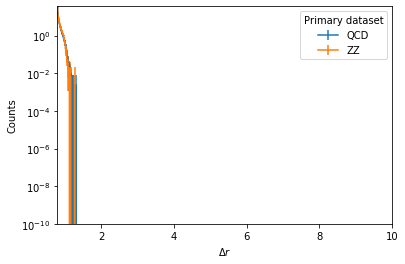

In [6]:
fig, ax = hist.plotgrid(output['dr'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
plt.ylim(1e-10)
plt.yscale("log")
fig.show()
fig.savefig("dr_plot.png")

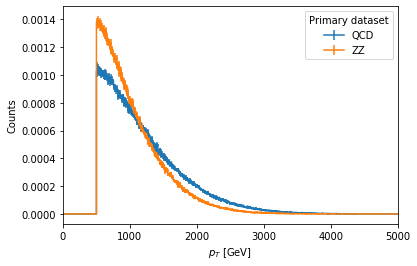

In [7]:
fig, ax = hist.plotgrid(output['pt'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()
fig.savefig("pt_plot.png")

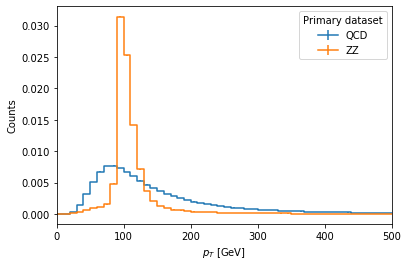

In [8]:
fig, ax = hist.plotgrid(output['m'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

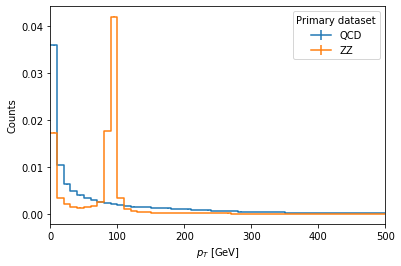

In [9]:
fig, ax = hist.plotgrid(output['m_sd'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

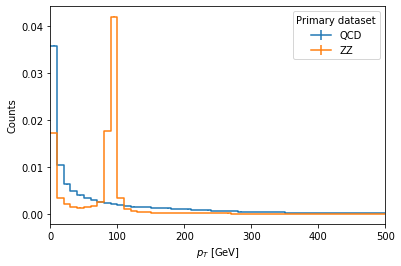

In [10]:
fig, ax = hist.plotgrid(output['m_sd_check'], overlay="dataset", stack=False, density=True
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

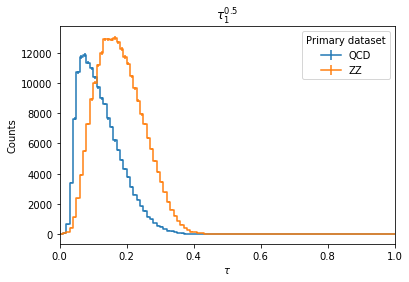

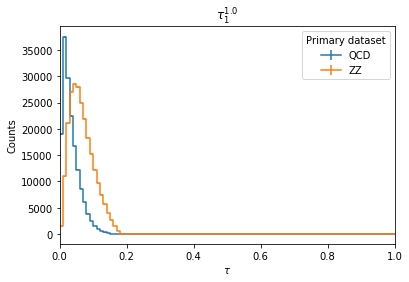

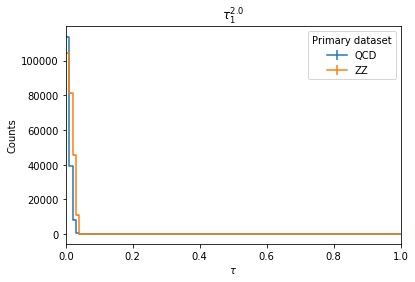

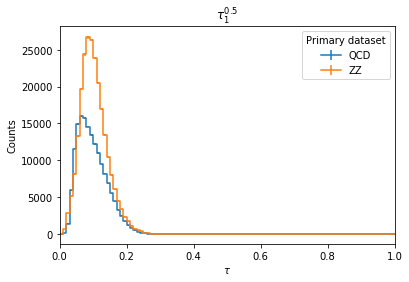

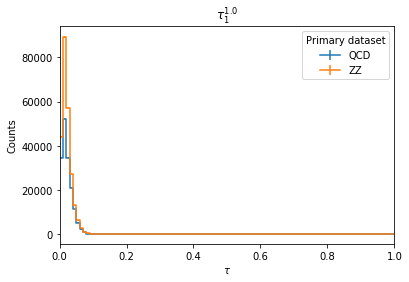

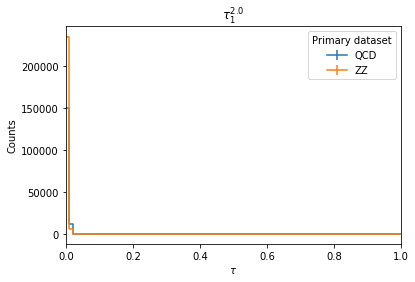

In [11]:
for i in [1,2]:
    for beta in ['05', '10', '20']:
        h = output['tau_%s_b%s_v_m' % (i,beta)].integrate('m', slice(70, 100) )
        
        fig, ax = hist.plotgrid(h, overlay='dataset', stack=False)
        for iax in ax.flatten():
            iax.autoscale(axis='y')
        plt.title(r'$\tau_{' + str(1) + '}^{' + beta[0] + '.' + beta[1] + '}$')
        fig.show()


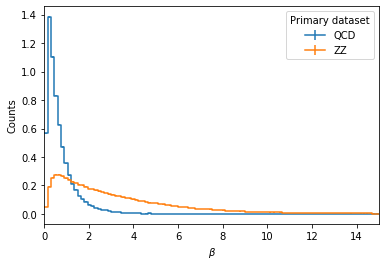

In [12]:
h = output['beta3_v_m'].integrate('m', slice(70, 100))

fig, ax = hist.plotgrid(h, overlay='dataset', stack=False, density=True )
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

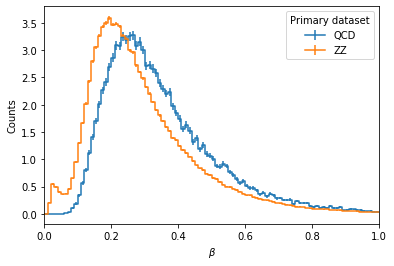

In [13]:
h = output['beta3_v_m_sd'].integrate('m', slice(70, 100) )

fig, ax = hist.plotgrid(h, overlay='dataset', stack=False, density=True)
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

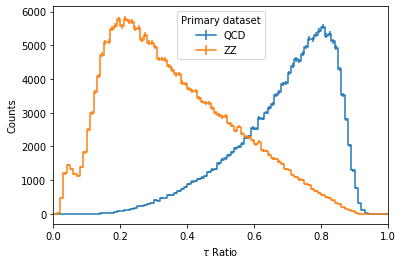

In [14]:
h = output['tau_21_b10_v_m'].integrate('m', slice(70, 100) )

fig, ax = hist.plotgrid(h, overlay='dataset', stack=False)
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

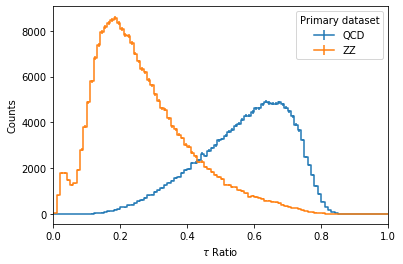

In [15]:
h = output['tau_31_b10_v_m'].integrate('m', slice(70, 100) )

fig, ax = hist.plotgrid(h, overlay='dataset', stack=False)
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()

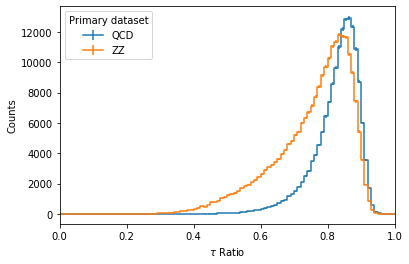

In [16]:
h = output['tau_32_b10_v_m'].integrate('m', slice(70, 100) )

fig, ax = hist.plotgrid(h, overlay='dataset', stack=False)
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()